In [ ]:
import json
import pandas as pd 
import numpy as np
import os
import re
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy

# Ensure all densities are normalized to sum to 1
def normalize_density(density):
    return density / np.sum(density)
# Mutual Information calculation
def kl_divergence(p_density, q_density):
    p_density = normalize_density(p_density)
    q_density = normalize_density(q_density)
    return entropy(p_density, q_density)

In [3]:
# Put data under /data/gpt_annotations
path = '../data/gpt_annotations/'
for root, folders, files in os.walk(path):
    folder_list = folders
    break

In [4]:
real_path = '../data/ICNALE_annotations'
for root, folders, files in os.walk(real_path):
    real_folder_list = folders
    break

In [5]:
real_path_mapping = {'SD_1_Classified_Unmerged_qn': "Quantifiers Numerals",
                'SD_1_Classified_Unmerged_na': "Numbers Agreement",
                'SD_1_Classified_Unmerged_rw': "Reference Word",
                'SD_1_Classified_Unmerged_ta': "Tense Agreement",
                'SD_1_Classified_Unmerged_mve': "Modal Verbs Expressions",
                'SD_1_Classified_Unmerged_sva': "Subject Verb Agreement",
                'SD_1_Classified_Unmerged_sa': "Speech Acts",
                'SD_1_Classified_Unmerged_nvc': "Noun Verb Collocation"
                }

path_mapping = {'gpt_generation_quantifiers_numerals': "Quantifiers Numerals",
                'gpt_generation_tense_agreemen': "Tense Agreement",
                'gpt_generation_reference_word': "Reference Word",
                'gpt_generation_numbers_agreemen': "Numbers Agreement",
                'gpt_generation_speech_acts': "Speech Acts",
                'gpt_generation_subject_verb_agreemen': "Subject Verb Agreement",
                'gpt_generation_modal_verbs_expressions': "Modal Verbs Expressions",
                'gpt_generation_noun_verb_collocation': "Noun Verb Collocation"}

revert_mapping = {v: k for k, v in path_mapping.items()}
revert_real_mapping = {v: k for k, v in real_path_mapping.items()}

In [ ]:
# put the data under /data/gpt_annotations
topic = "Modal Verbs Expressions"

feature = revert_mapping[topic]
pattern = r"([^/]+)_dialog$"
path = f'../data/gpt_annotations/{feature}'

all_data = pd.DataFrame()
count = 0

for root, _, files in os.walk(path):
    if count == 0:
        count = count+1
        continue 
    language = re.search(pattern, root).group(1)
    for json_file in files:
        if json_file.endswith('.json'):
            file_path = os.path.join(root, json_file)
            try:
                data = pd.read_json(file_path)
                filename = os.path.splitext(json_file)[0]
                data['source_file'] = filename
                data['language'] = language
                all_data = pd.concat([all_data, data], ignore_index=True)
            except ValueError as e:
                print(f"Error reading {file_path}: {e}")
    count = count + 1
    
    
real_all_data = pd.DataFrame()

def parse_filename(filename):
    pattern = r"SD_(\w+)_\d+_.*_(\d+)_([\w+]+)"
    match = re.match(pattern, filename)
    if match:
        language = match.group(1) 
        number = match.group(2)    
        chapter = match.group(3)   
        return language, number, chapter
    return None, None, None

real_feature = revert_real_mapping[topic]
real_path =  f'../data/ICNALE_annotations/{real_feature}'
for root, _, files in os.walk(real_path):
    for json_file in files:
        if json_file.endswith('.json'):
            file_path = os.path.join(root, json_file)
            try:
                data = pd.read_json(file_path)
                filename = os.path.splitext(json_file)[0]
                language, number, chapter = parse_filename(filename)
                data['source_file'] = filename
                data['language'] = language
                data['number'] = number
                data['chapter'] = chapter
                real_all_data = pd.concat([real_all_data, data], ignore_index=True)
            except ValueError as e:
                print(f"Error reading {file_path}: {e}")

if topic == "Modal Verbs Expressions":   
    real_all_data['type'] = 'modal_verb_annotation'
    

if feature in [revert_mapping['Reference Word'],
               revert_mapping['Numbers Agreement'],
               revert_mapping['Modal Verbs Expressions'],
               revert_mapping['Noun Verb Collocation']
]:
    all_data['token_num'] = 1
else:
    all_data['token_num'] = all_data['annotation_token'].apply(lambda x: len(x))


if real_feature in [revert_real_mapping['Reference Word'],
               revert_real_mapping['Numbers Agreement'],
               revert_real_mapping['Modal Verbs Expressions'],
               revert_real_mapping['Noun Verb Collocation']]:
    real_all_data['token_num'] = 1
else:
    real_all_data['token_num'] = real_all_data['annotation_token'].apply(lambda x: len(x))
real_counts = real_all_data.groupby(['language', 'source_file'])['token_num'].sum().reset_index()
counts = all_data.groupby(['language', 'source_file'])['token_num'].sum().reset_index()
#grammar_counts = all_data.groupby(['language', 'source_file'])['grammar_correctness'].apply(lambda x: x.str.contains('wrong').sum()).reset_index()

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

language_mapping = {
    'cantonese': 'CAN',
    'hai': 'HAI',
    'japanese': 'JPN',
    'korean': 'KOR',
    'malay': 'MAL',
    'mandarin': 'MAN',
    'mono_eng': 'ENG',
    'urdu': 'URD'
}

real_language_mapping = {
    'CHN': 'MAN',  # Mandarin (China)
    'ENS': 'ENG',  # Mono English
    'HKG': 'CAN',  # Cantonese (Hong Kong)
    'IDN': 'MAL',  # Malay (Indonesia)
    'JPN': 'JPN',  # Japanese
    'KOR': 'KOR',  # Korean
    'MYS': 'MAL',  # Malay (Malaysia)
    'PAK': 'URD',  # Urdu (Pakistan)
    'PHL': 'MAL',  # Malay (Philippines)
    'THA': 'THA',  # No equivalent, keep as is or map to 'MAL' if needed
    'TWN': 'MAN2'   # Mandarin (Taiwan)
}

revert_lan_real_mapping = {v: k for k, v in real_language_mapping.items()}
revert_lan_mapping = {v: k for k, v in language_mapping.items()}

language = 'MAN'
eng_language = 'ENG'

lang_counts = counts[counts['language'] == revert_lan_mapping[language]]['token_num']
eng_lang_counts = counts[counts['language'] == revert_lan_mapping[eng_language]]['token_num']
real_lang_counts = real_counts[real_counts['language'] == revert_lan_real_mapping[language]]['token_num']
real_lang_ens_counts = real_counts[real_counts['language'] == revert_lan_real_mapping[eng_language]]['token_num']

generated_l2_density = gaussian_kde(lang_counts)
real_l2_density = gaussian_kde(real_lang_counts)
mono_eng_density = gaussian_kde(eng_lang_counts)

density = gaussian_kde(lang_counts)
x_vals = np.linspace(min(lang_counts), max(lang_counts), 1000)
y_vals = density(x_vals)
#plt.plot(x_vals, y_vals, label=f'{language} L2 Generated')

density = gaussian_kde(eng_lang_counts)
x_vals = np.linspace(min(eng_lang_counts), max(eng_lang_counts), 1000)
y_vals = density(x_vals)
#plt.plot(x_vals, y_vals, label=f'Mono English Generated')

density = gaussian_kde(real_lang_counts)
x_vals = np.linspace(min(real_lang_counts), max(real_lang_counts), 1000)
y_vals = density(x_vals)
#plt.plot(x_vals, y_vals, label=f'{language} L2 Real')


density = gaussian_kde(real_lang_ens_counts)
x_vals = np.linspace(min(real_lang_ens_counts), max(real_lang_ens_counts), 1000)
y_vals = density(x_vals)
#plt.plot(x_vals, y_vals, label=f'Real English Generated')

kl_divergence(generated_l2_density(x_vals), real_l2_density(x_vals))
kl_divergence(mono_eng_density(x_vals), real_l2_density(x_vals))


# plt.title(f'Density Estimation for {topic} by {language}')
# plt.xlabel('Count')
# plt.ylabel('Density')
# plt.legend()



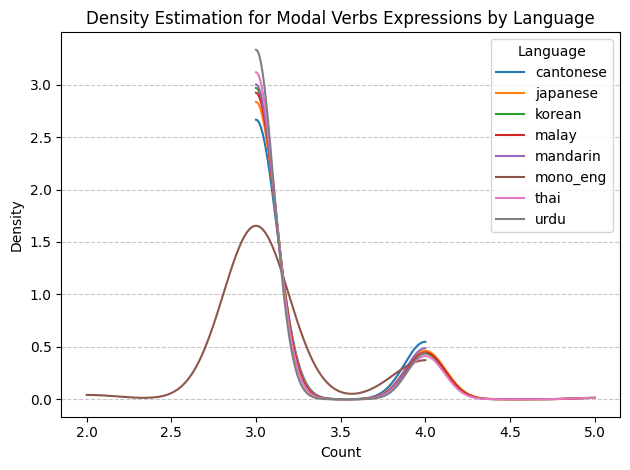

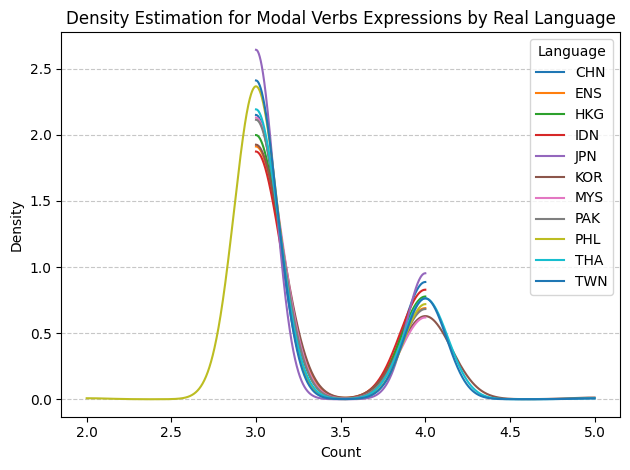

In [ ]:
languages = counts['language'].unique()

for language in languages:
    lang_counts = counts[counts['language'] == language]['token_num']
    density = gaussian_kde(lang_counts)
    x_vals = np.linspace(min(lang_counts), max(lang_counts), 1000)
    y_vals = density(x_vals)
    plt.plot(x_vals, y_vals, label=language)
    
plt.title(f'Density Estimation for {topic} by Language')
plt.xlabel('Count')
plt.ylabel('Density')
plt.legend(title="Language")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

languages = real_counts['language'].unique()

for language in languages:
    lang_counts = real_counts[real_counts['language'] == language]['token_num']
    density = gaussian_kde(lang_counts)
    x_vals = np.linspace(min(lang_counts), max(lang_counts), 1000)
    y_vals = density(x_vals)
    plt.plot(x_vals, y_vals, label=language)
    
plt.title(f'Density Estimation for {topic} by Real Language')
plt.xlabel('Count')
plt.ylabel('Density')
plt.legend(title="Language")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()